# AWS 환경설정

* `export AWS_DEFAULT_PROFILE=ghpipeliner` 실행
* 원하는 aws profile로 잘 변경되었는지 확인
    ```
    aws s3 ls
    ```

In [8]:
import boto3
import pandas as pd
import numpy as np
import json

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta

# making dummy data
from random import random

# Load Data

In [2]:
session = boto3.session.Session(profile_name='ghpipeliner')
s3 = session.client('s3')

In [12]:
from_dt = datetime(2023, 1, 2)
to_dt = datetime(2023, 1, 14)

dt = from_dt
df = pd.DataFrame()
cols = [
    'candle_date_time_kst', 'open', 'high', 'low', 'close', 'volume',
    'sentiment', 'new_author_rate', 'heavy_author_rate',
]
while(dt <= to_dt):
    print(f"Reading {dt}...")
    for hr in range(24):
        file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=1)} candles.json'
        try:
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        except:
            file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=2)} candles.json'
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        obj = json.loads(response['Body'].read().decode('utf-8'))
        dic_with_sentiment = []

        # create dummy data
        for row in obj['candles']:
            row['sentiment'] = 2 * random() -1 
            row['new_author_rate'] = random()
            row['heavy_author_rate'] = random()

            dic_with_sentiment.append(row)
        
        df = pd.concat([df, pd.DataFrame(dic_with_sentiment)[cols]])
    dt = dt + timedelta(days=1)
    
df.reset_index(drop=True, inplace=True)
df['candle_date_time_kst'] = df['candle_date_time_kst'].astype(dtype=np.datetime64)
df

Reading 2023-01-02 00:00:00...
Reading 2023-01-03 00:00:00...
Reading 2023-01-04 00:00:00...
Reading 2023-01-05 00:00:00...
Reading 2023-01-06 00:00:00...
Reading 2023-01-07 00:00:00...
Reading 2023-01-08 00:00:00...
Reading 2023-01-09 00:00:00...
Reading 2023-01-10 00:00:00...
Reading 2023-01-11 00:00:00...
Reading 2023-01-12 00:00:00...
Reading 2023-01-13 00:00:00...
Reading 2023-01-14 00:00:00...


,candle_date_time_kst,open,high,low,close,volume,sentiment,new_author_rate,heavy_author_rate
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518,0.021328,0.844905,0.258904
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599,0.193871,0.683672,0.771100
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290,-0.510454,0.444190,0.158654
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292,0.798509,0.535660,0.417449
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756,0.808547,0.385814,0.383616
...,...,...,...,...,...,...,...,...,...
18715,2023-01-14 23:01:00,25982000.0,25988000.0,25969000.0,25984000.0,23.919694,0.636359,0.202007,0.715294
18716,2023-01-14 23:02:00,25981000.0,26000000.0,25971000.0,25971000.0,20.102817,0.784641,0.312050,0.214911
18717,2023-01-14 23:03:00,25971000.0,25980000.0,25943000.0,25948000.0,11.595073,-0.143526,0.924875,0.955473
18718,2023-01-14 23:04:00,25948000.0,25976000.0,25940000.0,25970000.0,17.004231,-0.996845,0.058850,0.315225


# Preprocess Data
* n분후 `상승` or `하락` 예측 (`유지`도 상승에 포함)

In [13]:
n = 15
df['target'] = df.shift(-n)['close']
df.loc[df['target'] < df['close'], 'target'] = 0  # 순서 주의
df.loc[df['target'] >= df['close'], 'target'] = 1 # 순서 주의
data = df.iloc[:len(df) - n]
data

,candle_date_time_kst,open,high,low,close,volume,sentiment,new_author_rate,heavy_author_rate,target
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518,0.021328,0.844905,0.258904,1.0
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599,0.193871,0.683672,0.771100,1.0
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290,-0.510454,0.444190,0.158654,0.0
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292,0.798509,0.535660,0.417449,1.0
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756,0.808547,0.385814,0.383616,0.0
...,...,...,...,...,...,...,...,...,...,...
18700,2023-01-14 22:46:00,25902000.0,25936000.0,25902000.0,25936000.0,10.017290,-0.907544,0.481590,0.403444,1.0
18701,2023-01-14 22:47:00,25918000.0,25933000.0,25908000.0,25910000.0,6.703668,0.288829,0.422421,0.010279,1.0
18702,2023-01-14 22:48:00,25910000.0,25950000.0,25878000.0,25945000.0,24.123577,-0.390710,0.544375,0.813066,1.0
18703,2023-01-14 22:49:00,25940000.0,25964000.0,25936000.0,25962000.0,36.878548,0.946849,0.069836,0.546591,1.0


In [14]:
data_train = data.iloc[:int(len(data) * 0.8)]
data_test = data.iloc[int(len(data) * 0.8):]

print('Data for Modeling: ', str(data_train.shape))
print('Unseen Data for Predictions: ', str(data_test.shape))

Data for Modeling:  (14964, 10)
Unseen Data for Predictions:  (3741, 10)


# Train Model

* pycaret sample notebook: [classification beginer tutorial](https://www.pycaret.org/tutorials/html/CLF101.html)

In [15]:
from pycaret.classification import *

In [16]:
exp_reg001 = setup(data=data_train, target='target', session_id=1)

,Description,Value
0,session_id,1
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(14964, 10)"
5,Missing Values,0
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,0
9,High Cardinality Features,0


In [17]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5738,0.5881,0.6440,0.6007,0.6216,0.1351,0.1356,0.2030
gbc,Gradient Boosting Classifier,0.5678,0.5664,0.8361,0.5698,0.6777,0.0882,0.1046,0.3240
knn,K Neighbors Classifier,0.5643,0.5792,0.6266,0.5939,0.6098,0.1172,0.1175,0.0760
lightgbm,Light Gradient Boosting Machine,0.5639,0.5717,0.7304,0.5784,0.6455,0.0983,0.1028,0.0330
rf,Random Forest Classifier,0.5636,0.5814,0.6609,0.5876,0.6220,0.1099,0.1111,0.2870
ada,Ada Boost Classifier,0.5577,0.5563,0.7791,0.5679,0.6568,0.0757,0.0839,0.0910
nb,Naive Bayes,0.5574,0.5528,0.6080,0.5905,0.5989,0.1054,0.1055,0.0160
lr,Logistic Regression,0.5556,0.5556,0.7575,0.5683,0.6493,0.0750,0.0814,0.3860
ridge,Ridge Classifier,0.5555,0.0000,0.7552,0.5685,0.6485,0.0752,0.0814,0.0060
lda,Linear Discriminant Analysis,0.5553,0.5556,0.7540,0.5685,0.6481,0.0750,0.0811,0.0220


In [18]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5391,0.5207,0.7263,0.5587,0.6316,0.0435,0.0462
1,0.5735,0.5826,0.7456,0.5846,0.6554,0.1169,0.1230
2,0.5668,0.5729,0.7316,0.5808,0.6475,0.1045,0.1092
3,0.5668,0.5717,0.7088,0.5838,0.6403,0.1085,0.1118
4,0.5396,0.5577,0.7100,0.5603,0.6264,0.0481,0.0504
5,0.5606,0.5783,0.7417,0.5741,0.6472,0.0893,0.0946
6,0.5654,0.5603,0.7135,0.5817,0.6409,0.1049,0.1085
7,0.5845,0.5857,0.7329,0.5957,0.6572,0.1440,0.1490
8,0.5922,0.6074,0.7610,0.5981,0.6698,0.1562,0.1641


In [19]:
tuned_lgbm = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5515,0.5261,0.8193,0.5600,0.6652,0.0539,0.0637
1,0.5429,0.5483,0.8018,0.5553,0.6561,0.0377,0.0437
2,0.5468,0.5520,0.8123,0.5572,0.6610,0.0444,0.0521
3,0.5477,0.5410,0.7772,0.5608,0.6515,0.0532,0.0593
4,0.5291,0.5205,0.7750,0.5471,0.6415,0.0119,0.0135
5,0.5578,0.5641,0.8366,0.5626,0.6728,0.0655,0.0790
6,0.5645,0.5590,0.8207,0.5688,0.6719,0.0837,0.0970
7,0.5606,0.5551,0.8084,0.5672,0.6667,0.0773,0.0884
8,0.5559,0.5796,0.8102,0.5636,0.6647,0.0661,0.0763


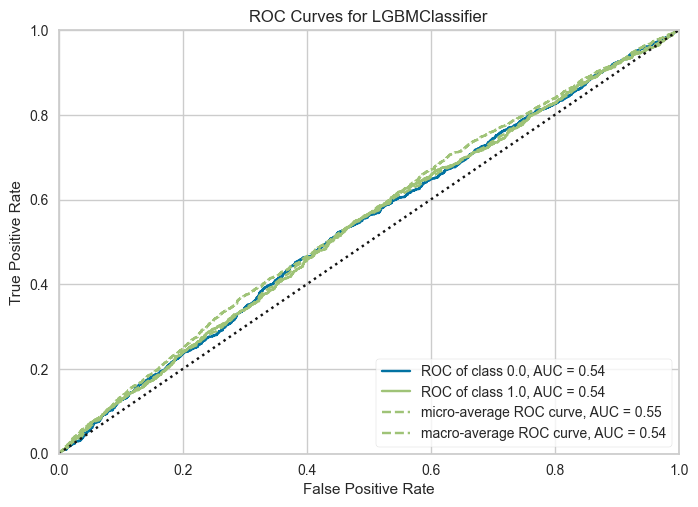

In [20]:
plot_model(tuned_lgbm)

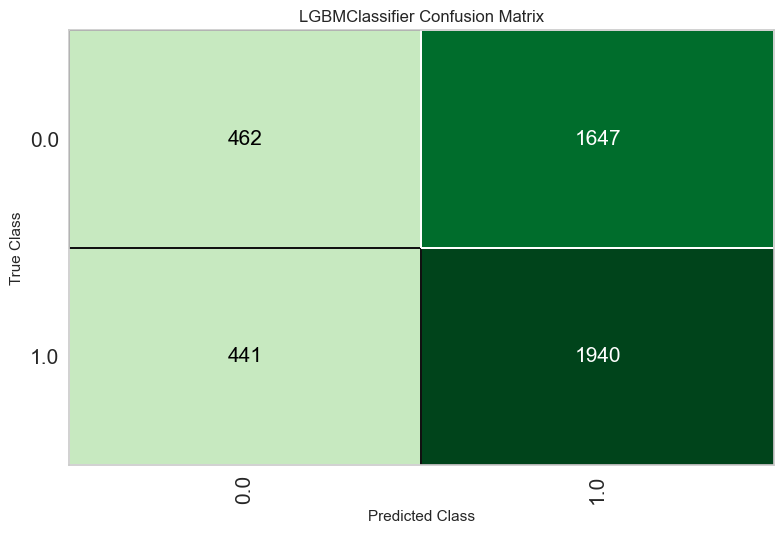

In [21]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')

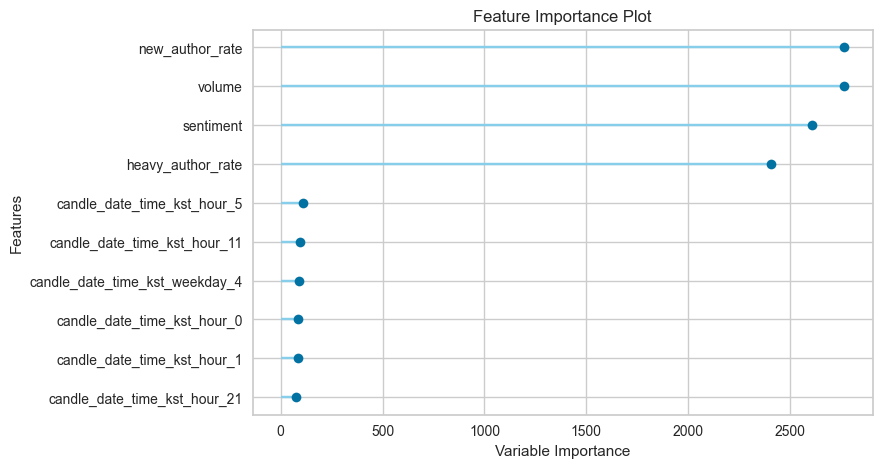

In [22]:
plot_model(tuned_lgbm, plot='feature')

In [23]:
final_lgbm = finalize_model(tuned_lgbm)
print(final_lgbm)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] 
bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored.

In [24]:
unseen_predictions = predict_model(final_lgbm, data=data_test)
unseen_predictions.head(10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5509,0.5258,0.6699,0.6145,0.6410,0.0444,0.0447


,candle_date_time_kst,open,high,low,close,volume,sentiment,new_author_rate,heavy_author_rate,target,Label,Score
14964,2023-01-12 08:30:00,22132000.0,22163000.0,22120000.0,22163000.0,2.863706,-0.023726,0.206669,0.863433,1.0,1.0,0.6294
14965,2023-01-12 08:31:00,22163000.0,22167000.0,22161000.0,22162000.0,6.822875,-0.896043,0.175081,0.732363,1.0,1.0,0.6051
14966,2023-01-12 08:32:00,22162000.0,22240000.0,22161000.0,22230000.0,36.114889,-0.763032,0.730380,0.509841,1.0,0.0,0.5255
14967,2023-01-12 08:33:00,22230000.0,22415000.0,22224000.0,22403000.0,60.997269,0.023580,0.149377,0.912950,1.0,1.0,0.5171
14968,2023-01-12 08:34:00,22400000.0,22498000.0,22377000.0,22475000.0,27.666239,0.891157,0.969602,0.567676,0.0,1.0,0.5136
14969,2023-01-12 08:35:00,22473000.0,22498000.0,22415000.0,22432000.0,34.066196,-0.781353,0.515834,0.516660,1.0,0.0,0.5377
14970,2023-01-12 08:36:00,22419000.0,22460000.0,22419000.0,22448000.0,36.027856,-0.024971,0.677080,0.548899,1.0,1.0,0.5048
14971,2023-01-12 08:37:00,22439000.0,22501000.0,22437000.0,22492000.0,34.359781,-0.757826,0.050285,0.071242,0.0,0.0,0.5018
14972,2023-01-12 08:38:00,22499000.0,22499000.0,22449000.0,22470000.0,13.902834,0.062327,0.941433,0.597896,0.0,1.0,0.5111
14973,2023-01-12 08:39:00,22470000.0,22470000.0,22401000.0,22422000.0,14.684522,-0.445361,0.529432,0.110722,1.0,1.0,0.5346


In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

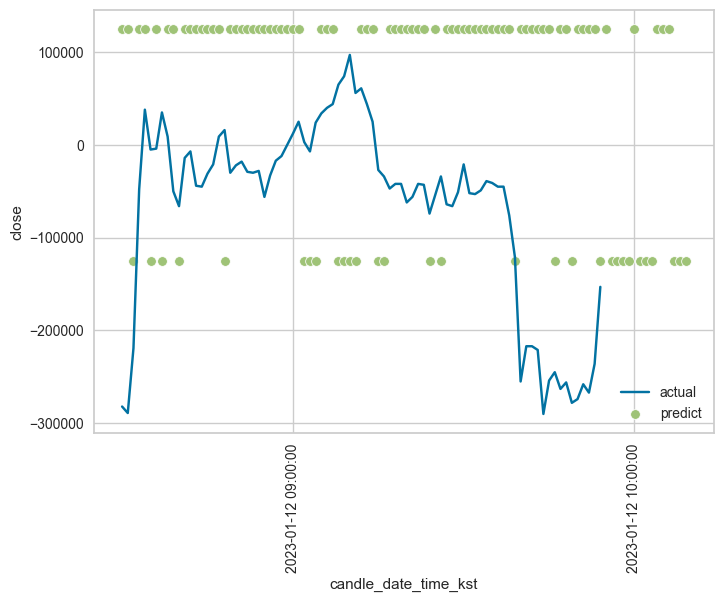

In [28]:
fig, ax = plt.subplots()

to_see_data = unseen_predictions.head(100)

sns.lineplot(x=to_see_data['candle_date_time_kst'], y=to_see_data['close'] - to_see_data.shift(-n)['close'], label='actual', ax=ax)
sns.scatterplot(x=to_see_data['candle_date_time_kst'], y=(to_see_data['Label'].astype(float) - 0.5) * 250000, label='predict', ax=ax, color = 'g')

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), rotation=90)
fig.show()

In [29]:
from sklearn.metrics import confusion_matrix

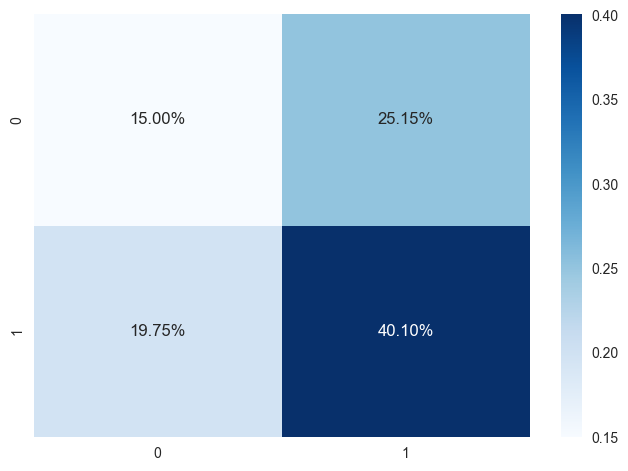

In [30]:
cf_matrix = confusion_matrix(unseen_predictions['target'].astype(float), unseen_predictions['Label'].astype(float))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [31]:
create_api(final_lgbm, 'lgbm_api', host='0.0.0.0')


API sucessfully created. This function only creates a POST API, it doesn't run it automatically.

To run your API, please run this command --> !python lgbm_api.py
    


In [32]:
create_docker('lgbm_api')

Writing requirements.txt
Writing Dockerfile
Dockerfile and requirements.txt successfully created.
To build image you have to run --> !docker image build -f "Dockerfile" -t IMAGE_NAME:IMAGE_TAG .
        


```shell
docker image build . -t pycaret_lgbm:latest
```

```shell
docker tag pycaret_lgbm:latest 433166909747.dkr.ecr.ap-northeast-2.amazonaws.com/pycaret_lgbm
aws ecr get-login-password --region ap-northeast-2 | docker login --username AWS --password-stdin 433166909747.dkr.ecr.ap-northeast-2.amazonaws.com
docker push 433166909747.dkr.ecr.ap-northeast-2.amazonaws.com/pycaret_lgbm
```